# Transmission Profile Processing

This notebook processes the data collected in the measurement notebook to produce Signal-to-Noise plots and the final transmission profile of the sapphire coating sample.

Sam Condon \
Caltech \
05/18/2021

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as spfft

## Define Functions

#### Time series plotting

In [2]:
#plot sample time series, histogram, and fourier transform
def plot_time_hist(t, working_samps, plot_title='Sample', fig_title=None):
    fig, plts = plt.subplots(1,2, figsize=(15,5))

    if fig_title is not None:
        fig.suptitle(fig_title)
    
    sample_mean = round(working_samps.mean(), 2)
    sample_std = round(working_samps.std(), 2)
    
    plts[0].plot(t, 1e3*working_samps)
    plts[0].set_title('{} Time Series'.format(plot_title))
    plts[0].set_xlabel('Time (s.)')
    plts[0].set_ylabel('Detector Voltage (mV.)')

    plts[1].hist(1e3*working_samps, bins=10)
    plts[1].set_title(r'{} Histogram: $\mu = {}$ $\sigma = {}$'.format(plot_title, sample_mean, sample_std))
    plts[1].set_xlabel('Detector Voltage (mV.)')
    plts[1].set_ylabel('Occurences')

#### FFT

In [3]:
def fft(samples, fs, N=None, ax=None, plot=True):
    if N == None:
        N = len(samples)
    
    samps_fft = (2/N)*spfft.fft(samples, n=N) #take fft and scale by number of points
    freqs = spfft.fftshift(spfft.fftfreq(samples.size, d=1/fs)) #shift for zero frequency in center
    samps_fft = spfft.fftshift(samps_fft)
    samps_fft_mag = np.absolute(samps_fft)
    
    samps_fft_mag[np.where(freqs == 0)] /= 2 #scale dc value
    
    fft_dict = {'fft': samps_fft, 'fft_mags': samps_fft_mag,
                'freqs': freqs}
    
    if ax is None and plot:
        fft_fig, ax = plt.subplots(figsize=(10,5))
    
    if plot:
        ax.plot(fft_dict['freqs'], fft_dict['fft_mags'])
        ax.set_title('Sample FFT')
        ax.set_xlabel('Frequency (Hz.)')
        ax.set_ylabel('Amplitude (V.)')

    return fft_dict

#### Total power in a magnitude spectrum after moving average filtering

In [4]:
def noise_power_calc(fft_mags, fft_freqs, int_t):
    #Frequency response of moving average filter applied from integration
    Hma = np.abs(np.sinc(fft_freqs*int_t))
    #Apply filtering in fourier space
    fft_mags_integrated = np.multiply(Hma, fft_mags)
    #Convert to two-sided power spectral density
    psd_integrated = (1/4)*(fft_mags_integrated**2)
    #return total power
    return np.sum(psd_integrated)

## Preprocessing

#### Get metadata for all signal and noise measurements

In [5]:
with open('metadata.json') as f:
    data = json.load(f)
measurements = np.array(data['measurements']) 
measurement_types = np.array([m['type'] for m in measurements]) #create array of all measurement types
measurement_lockins = np.array([m['lock-in'] for m in measurements])
measurement_attenuators = np.array([m['attenuators'] for m in measurements])

#### Arrange metadata for all signal (no attenuation) measurements

In [6]:
mask1 = np.where(measurement_types == 'signal')[0]
mask2 = np.where(measurement_attenuators == None)[0]
signal_measurements = measurements[np.intersect1d(mask1, mask2)]
SmSensitivities = np.array([sm['lock-in']['sensitivity'] for sm in signal_measurements]) 

#### Open associated csvs for all signal (no attenuation) measurements

In [7]:
signal_dfs = [pd.read_csv(sm['file-name']) for sm in signal_measurements]

In [8]:
signal_voltages = np.array([df['Detector Voltage'].values for df in signal_dfs])
#scale time series voltages by appropriate gain out of lock-in
signal_voltages = np.array([signal_voltages[ind] * (SmSensitivities[ind]/10) for ind in range(len(SmSensitivities))])
signal_types = np.array([[signal_measurements[ind]['monochromator']['wavelength']
                             for sv in signal_voltages[ind]] for ind in range(len(signal_voltages))])

sm_freqs = [sm['sample-frequency'] for sm in signal_measurements]
signal_sample_times = np.array([np.arange(0, (1/sm_freqs[i])*len(signal_voltages[i]), 1/sm_freqs[i]) 
                           for i in range(len(signal_voltages))])

signal_voltages = signal_voltages.flatten()
signal_types = signal_types.flatten()
signal_sample_times = signal_sample_times.flatten()

#### Convert to signal (no attenuation) data to dataframe

In [9]:
NoAttenDf = pd.DataFrame({'Type': signal_types, 'Time': signal_sample_times, 'Voltage': signal_voltages})

#### Arrange metadata for all signal (coating attenuated) and noise measurements

In [10]:
noise_measurements = measurements[np.where(measurement_types == 'noise')[0]]
NmSensitivities = np.array([nm['lock-in']['sensitivity'] for nm in noise_measurements])
coating_measurements = []
#coating signal measurements are obviously not noise measurements
mask1 = np.where(noise_measurements != measurements)[0] 
#only concerned w/ signal to noise where attenuator is used
mask2 = np.where(measurement_attenuators != None)[0]
cm_ind = 0
for nm in noise_measurements:
    #lock in settings of each signal and noise measurement should be the same
    mask3 = np.where(measurement_lockins == nm['lock-in'])[0]
    mask_final = np.intersect1d(mask3, np.intersect1d(mask1, mask2))
    coating_measurements.append(measurements[mask_final]) #append list of coating signal measurements
                                                          #associated with each noise measurement
CmSensitivities = np.array([cm['lock-in']['sensitivity'] for cm in coating_measurements[0]])
 

#### Open csvs for all metadata objects extracted previously and format data into flattened arrays 

In [11]:
coating_dfs = [pd.read_csv(cm['file-name']) for cm in coating_measurements[0]]
noise_dfs = [pd.read_csv(nm['file-name']) for nm in noise_measurements]

In [12]:
coating_voltages = np.array([df['Detector Voltage'].values for df in coating_dfs])
coating_voltages = np.array([coating_voltages[ind]*CmSensitivities[ind]/10 for ind in range(len(CmSensitivities)) ])
coating_types = np.array([[coating_measurements[0][ind]['monochromator']['wavelength']
                             for cv in coating_voltages[ind]] for ind in range(len(coating_voltages))])

cm_freqs = [cm['sample-frequency'] for cm in coating_measurements[0]]
coating_sample_times = np.array([np.arange(0, (1/cm_freqs[i])*len(coating_voltages[i]), 1/cm_freqs[i]) 
                           for i in range(len(coating_voltages))])

#Flatten extracted coating data
coating_voltages = coating_voltages.flatten()
coating_types = coating_types.flatten()
coating_sample_times = coating_sample_times.flatten()

In [13]:
noise_voltages = np.array([df['Detector Voltage'].values for df in noise_dfs])
noise_type_strs = np.array([('noise ' * len(nv)).split(' ')[:-1] for nv in noise_voltages])

nm_freqs = [nm['sample-frequency'] for nm in noise_measurements]
nm_sample_times = np.array([np.arange(0, (1/nm_freqs[i])*len(noise_voltages[i]), 1/nm_freqs[i]) 
                           for i in range(len(noise_voltages))])

#Flatten extracted noise data
noise_voltages = noise_voltages.flatten()
noise_type_strs = noise_type_strs.flatten()
nm_sample_times = nm_sample_times.flatten()

#### Combine coating and noise measurements into individual arrays and convert to Dataframe

In [14]:
voltages = np.concatenate([coating_voltages, noise_voltages])
times = np.concatenate([coating_sample_times, nm_sample_times])
types = np.concatenate([coating_types, noise_type_strs])

##Final pre-processed data frame used for subsequent computations
AttenDf = pd.DataFrame({'Type': types, 'Time': times, 'Voltage': voltages})

## Signal to Noise Computations

#### Plot mean removed noise time series

In [15]:
#grab signal measurements
AttenSigDf = AttenDf[np.invert(AttenDf['Type'].isin(['noise']))]

#grab noise measurements and remove mean
NoiseDf = AttenDf[AttenDf['Type'].isin(['noise'])]
NoiseVoltages = NoiseDf['Voltage'].values
NoiseVoltages = NoiseVoltages - NoiseVoltages.mean()
NoiseTimes = NoiseDf['Time'].values
NoiseFs = 1/(NoiseTimes[1] - NoiseTimes[0])

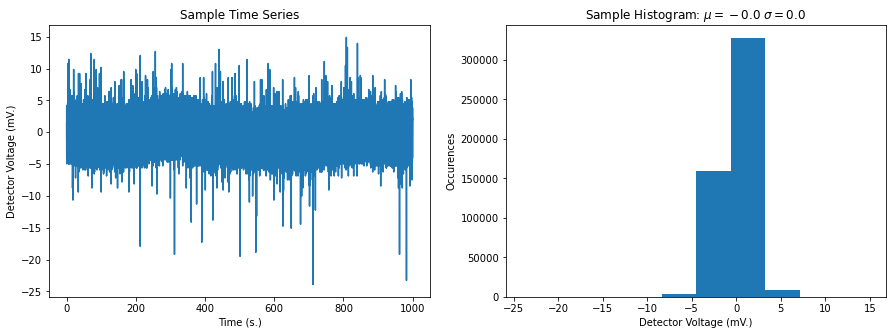

In [16]:
plot_time_hist(NoiseTimes, NoiseVoltages)

#### Noise FFT

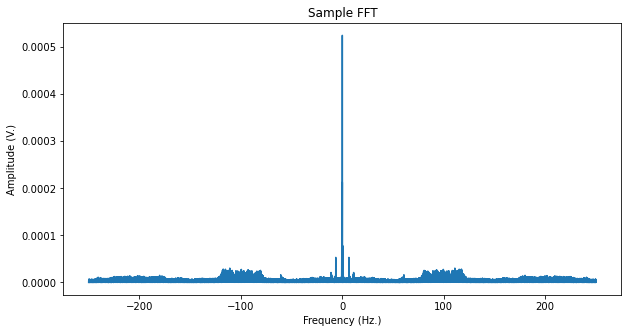

In [17]:
noise_fft = fft(NoiseVoltages, NoiseFs)

#### Noise power vs. integration time

In [31]:
IntegrationTimes = np.linspace(0.01, 1000, 100)
NoisePowers = np.array([noise_power_calc(noise_fft['fft_mags'], noise_fft['freqs'], int_t)
                        for int_t in integration_times])

Text(0, 0.5, 'Total noise power')

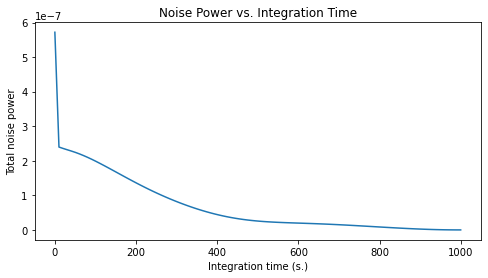

In [32]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(IntegrationTimes, NoisePowers)
ax.set_title('Noise Power vs. Integration Time')
ax.set_xlabel('Integration time (s.)')
ax.set_ylabel('Total noise power')

#### Signal amplitudes w/o sapphire attenuator

In [20]:
sig_waves = np.unique(NoAttenDf['Type'].values)
sig_noatten_amps = np.zeros(len(sig_waves))
ind = 0
for w in sig_waves:
    df = NoAttenDf[NoAttenDf['Type'].isin([w])]
    fs = 1/(df['Time'].values[1] - df['Time'].values[0])
    voltages = df['Voltage'].values
    sig_fft = fft(voltages, fs, plot=False)
    sig_noatten_amps[ind] = sig_fft['fft_mags'][np.where(sig_fft['freqs'] == 0)]
    ind += 1

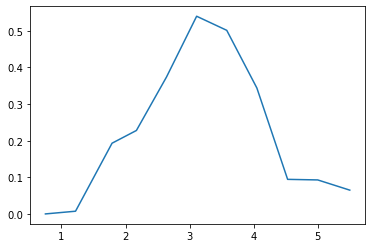

In [21]:
plt.plot(sig_waves, sig_noatten_amps)

#### Signal amplitudes w/ sapphire attenuator

In [22]:
#grab all wavelengths present in measurements
waves = np.unique(AttenSigDf['Type'].values)
sig_atten_amps = np.zeros(len(waves))
ind = 0
for w in waves:
    sig_df = AttenSigDf[AttenSigDf['Type'].isin([w])]
    sig_fs = 1/(sig_df['Time'].values[1] - sig_df['Time'].values[0])
    sig_voltages = sig_df['Voltage'].values
    sig_fft = fft(sig_voltages, sig_fs, plot=False)
    sig_atten_amps[ind] = sig_fft['fft_mags'][np.where(sig_fft['freqs'] == 0)]
    ind += 1

#sig_atten_amps = np.multiply(CmSensitivities/10, sig_amps)

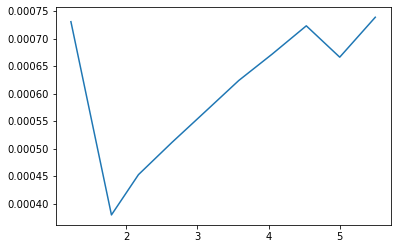

In [23]:
%matplotlib inline
plt.plot(waves.astype(float), sig_atten_amps)

#### Required integration time for a fixed snr as a function of wavelength

In [24]:
snr = 100

#### Transmission Profile (rough)

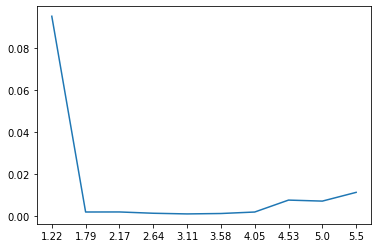

In [30]:
%matplotlib inline
transmission_profile = np.divide(sig_atten_amps, sig_noatten_amps[1:])
plt.plot(waves, transmission_profile)

#### Snr as function of integration time with varying wavelength

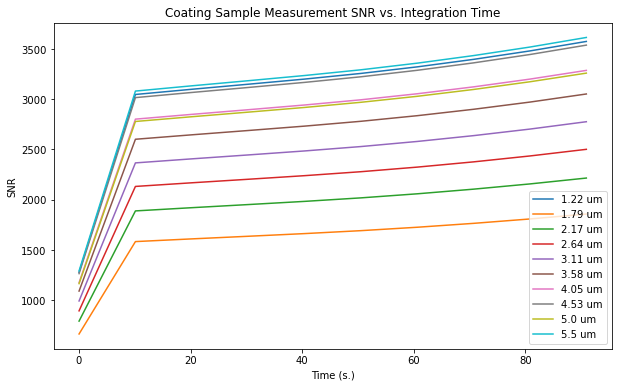

In [44]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,6))
w_ind = 0
for amp in sig_atten_amps:
    snr_curve = amp/NoisePowers
    ax.plot(IntegrationTimes[:10], snr_curve[:10], label='{} um'.format(waves[w_ind]))
    w_ind += 1
ax.set_title('Coating Sample Measurement SNR vs. Integration Time')
ax.set_xlabel('Time (s.)')
ax.set_ylabel('SNR')
ax.legend()